In [1]:
import geopandas as gpd

In [2]:
# The topic of interest
topic_dir = "/annual/kl/recent/"
print("Subdirectory on FTP Server:", topic_dir)

Subdirectory on FTP Server: /annual/kl/recent/


In [3]:
#local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

#local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [5]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//annual/kl/recent/
data/original/DWD//annual/kl/recent/

data/generated/DWD/
data/generated/DWD//annual/kl/recent/
data/generated/DWD//annual/kl/recent/
data/generated/DWD//annual/kl/recent/


In [6]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

In [7]:
# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"

# The absolute ftp directory with the data (topic) of concern
ftp_dir =  ftp_climate_data_dir + topic_dir
print("Absolte FTP directory path with data of concern:", ftp_dir)

Absolte FTP directory path with data of concern: /climate_environment/CDC/observations_germany/climate//annual/kl/recent/


In [8]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [9]:
ret = ftp.cwd(".")

In [10]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")

In [11]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [12]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [13]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,KL_Jahreswerte_Beschreibung_Stationen.txt,.txt,1202611,-
1,44,jahreswerte_KL_00044_akt.zip,.zip,14451,-
2,71,jahreswerte_KL_00071_akt.zip,.zip,13714,-
3,73,jahreswerte_KL_00073_akt.zip,.zip,15602,-
4,78,jahreswerte_KL_00078_akt.zip,.zip,10697,-
5,91,jahreswerte_KL_00091_akt.zip,.zip,12397,-
6,96,jahreswerte_KL_00096_akt.zip,.zip,13007,-
7,102,jahreswerte_KL_00102_akt.zip,.zip,11498,-
8,125,jahreswerte_KL_00125_akt.zip,.zip,4698,-
9,131,jahreswerte_KL_00131_akt.zip,.zip,13461,-


In [14]:
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
44,jahreswerte_KL_00044_akt.zip,.zip,14451,-
71,jahreswerte_KL_00071_akt.zip,.zip,13714,-
73,jahreswerte_KL_00073_akt.zip,.zip,15602,-
78,jahreswerte_KL_00078_akt.zip,.zip,10697,-
91,jahreswerte_KL_00091_akt.zip,.zip,12397,-
96,jahreswerte_KL_00096_akt.zip,.zip,13007,-
102,jahreswerte_KL_00102_akt.zip,.zip,11498,-
125,jahreswerte_KL_00125_akt.zip,.zip,4698,-
131,jahreswerte_KL_00131_akt.zip,.zip,13461,-


In [15]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

KL_Jahreswerte_Beschreibung_Stationen.txt


In [16]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//annual/kl/recent/KL_Jahreswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//annual/kl/recent/KL_Jahreswerte_Beschreibung_Stationen.txt


In [17]:
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", encoding="latin1")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(\
        txtfile, skiprows=2, names=colnames_en, \
        parse_dates=["date_from","date_to"], index_col = 0, \
        encoding="latin1")
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [18]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,1971-03-01,2023-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern


In [19]:
# Create variable with TRUE if state is Bayern
isBY = (df_stations['state'] == "Bayern").values
isActive2022 = (df_stations['date_to'] > "2022").values 
StartedBefore1950 = (df_stations['date_from'] < "1950").values 

# select on both conditions
station_ids_selected = df_stations[isBY & isActive2022 & StartedBefore1950].index

print(f"Stations located in BY and still active in 2022: \n{list(station_ids_selected)}")

Stations located in BY and still active in 2022: 
[151, 191, 217, 232, 282, 320, 867, 1103, 1107, 1279, 1332, 1357, 1550, 2261, 2290, 2480, 2559, 2597, 2600, 2680, 2700, 2750, 3244, 3271, 3307, 3621, 3668, 3679, 3730, 3739, 4104, 4261, 4287, 4592, 4911, 5017, 5111, 5149, 5397, 5404, 5440, 5538, 5705, 5792, 5941]


In [20]:
df_stations.loc[station_ids_selected].head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
151,1947-01-01,2023-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern
191,1884-01-01,2023-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern
217,1938-01-01,2023-12-31,670,47.8774,11.3643,Attenkam,Bayern
232,1947-01-01,2023-12-31,462,48.4253,10.9417,Augsburg,Bayern
282,1949-01-01,2023-12-31,240,49.8743,10.9206,Bamberg,Bayern


In [21]:
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations['longitude'], df_stations['latitude']), crs='EPSG:4326')

In [22]:
station_ids_selected = gdf_stations[isBY & isActive2022 & StartedBefore1950].index

In [23]:
gdf_selected_stations = gdf_stations.loc[station_ids_selected]

In [24]:
gdf_selected_stations = gdf_selected_stations.to_crs('EPSG:25832')

In [25]:
gdf_selected_stations.to_file('selected_stations.gpkg', layer='selected_stations', driver='GPKG')

In [26]:
local_zip_list = []

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

jahreswerte_KL_00151_akt.zip
jahreswerte_KL_00191_akt.zip
jahreswerte_KL_00217_akt.zip
jahreswerte_KL_00232_akt.zip
jahreswerte_KL_00282_akt.zip
jahreswerte_KL_00320_akt.zip
jahreswerte_KL_00867_akt.zip
jahreswerte_KL_01103_akt.zip
jahreswerte_KL_01107_akt.zip
jahreswerte_KL_01279_akt.zip
jahreswerte_KL_01332_akt.zip
jahreswerte_KL_01357_akt.zip
jahreswerte_KL_01550_akt.zip
jahreswerte_KL_02261_akt.zip
jahreswerte_KL_02290_akt.zip
jahreswerte_KL_02480_akt.zip
jahreswerte_KL_02559_akt.zip
jahreswerte_KL_02597_akt.zip
jahreswerte_KL_02600_akt.zip
jahreswerte_KL_02680_akt.zip
jahreswerte_KL_02700_akt.zip
jahreswerte_KL_02750_akt.zip
jahreswerte_KL_03244_akt.zip
jahreswerte_KL_03271_akt.zip
jahreswerte_KL_03307_akt.zip
jahreswerte_KL_03621_akt.zip
jahreswerte_KL_03668_akt.zip
jahreswerte_KL_03679_akt.zip
jahreswerte_KL_03730_akt.zip
jahreswerte_KL_03739_akt.zip
jahreswerte_KL_04104_akt.zip
jahreswerte_KL_04261_akt.zip
jahreswerte_KL_04287_akt.zip
jahreswerte_KL_04592_akt.zip
jahreswerte_KL

In [27]:
#date_from = '2019-05-01'
#date_to   = '2019-05-31'
date_from = '1700-01-01'
date_to   = '2100-12-31'

In [28]:
import datetime as dt

In [29]:
def prec_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [30]:
def kl_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [31]:
from zipfile import ZipFile
def ts_merge(date_from='1700-01-01', date_to='2100-12-31'):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [32]:
df_merged_ts = ts_merge(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00151_akt.zip
Extract product file: produkt_klima_jahr_20190101_20231231_00151.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00191_akt.zip
Extract product file: produkt_klima_jahr_20190101_20231231_00191.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00217_akt.zip
Extract product file: produkt_klima_jahr_20190101_20231231_00217.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00232_akt.zip
Extract product file: produkt_klima_jahr_20190101_20231231_00232.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00282_akt.zip
Extract product file: produkt_klima_jahr_20190101_20231231_00282.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00320_akt.zip
Extract product file: produkt_klima_jahr_20190101_20231231_00320.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00867_akt.zip
Extract product file: produkt_klim

C:\Users\demid\AppData\Local\Temp\ipykernel_29572\1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])
C:\Users\demid\AppData\Local\Temp\ipykernel_29572\3111996013.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
C:\Users\demid\AppData\Local\Temp\ipykernel_29572\1510806814.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please u

In [33]:
import seaborn as sns

In [34]:
data_path = r"../GeoData_WS2023_2_Final_D/data/original"
station_file_name = '/KL_Jahreswerte_Beschreibung_Stationen.txt'

In [35]:
full_fname = data_path + station_file_name
print(full_fname)

../GeoInfo_WS2023_2_Final_D/data/original/KL_Jahreswerte_Beschreibung_Stationen.txt


In [36]:
headers = open(full_fname).readline().split()
df_stat = pd.read_fwf(
    full_fname,
    encoding="cp1252",
    skiprows=2,
    names=headers,
    index_col="Stations_id", 
    parse_dates=["von_datum","bis_datum"])
df_stat

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,1971-03-01,2023-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern
...,...,...,...,...,...,...,...
19647,1951-01-01,2005-10-31,178,49.4547,8.9794,Eberbach/Neckar,Baden-Württemberg
19774,1971-08-19,1994-02-28,174,51.4814,10.8057,Nordhausen (Umspannwerk),Thüringen
19781,1881-01-01,1953-12-31,367,48.7429,11.4233,Ingolstadt,Bayern


In [37]:
idx_BY    = df_stat["Bundesland"] == "Bayern"
idx_active = df_stat["bis_datum"]  > "2021-12-31"
idx_early  = df_stat["von_datum"]   < "1950"

In [38]:
df_stat_short = df_stat[idx_BY & idx_active & idx_early]

In [39]:
df_stat_short

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
151,1947-01-01,2023-12-31,382,49.4691,11.8546,Amberg-Unterammersricht,Bayern
191,1884-01-01,2023-12-31,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern
217,1938-01-01,2023-12-31,670,47.8774,11.3643,Attenkam,Bayern
232,1947-01-01,2023-12-31,462,48.4253,10.9417,Augsburg,Bayern
282,1949-01-01,2023-12-31,240,49.8743,10.9206,Bamberg,Bayern
320,1851-01-01,2023-12-31,350,49.9666,11.5198,Heinersreuth-Vollhof,Bayern
867,1883-01-01,2023-12-31,344,50.3066,10.9679,Lautertal-Oberlauter,Bayern
1103,1938-01-01,2023-12-31,592,48.1003,11.9872,Ebersberg-Halbing,Bayern
1107,1948-01-01,2023-12-31,346,49.8520,10.4991,Ebrach,Bayern


In [40]:
import geopandas as gpd

# Load the GeoPackage file containing selected stations
selected_stations_gpkg = "selected_stations.gpkg"
gdf_selected_stations = gpd.read_file(selected_stations_gpkg)

In [41]:
import os
import requests
from bs4 import BeautifulSoup
import re

In [42]:
# Function to grab file from URL and save it to local directory
def grab_file(file_url, download_dir):
    # Get only the file name from the full URL
    file_name = file_url.split("/")[-1]
    # Download the file
    file_path = os.path.join(download_dir, file_name)
    with open(file_path, "wb") as file:
        file.write(requests.get(file_url).content)

In [43]:
# URL of the DWD website
url_base = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/"
url_temporal_resolution = "annual/"
url_parameter = "kl/"
url_subdir = "historical/"
url_full = os.path.join(url_base, url_temporal_resolution, url_parameter, url_subdir)


In [44]:
# Directory to save the downloaded files
download_dir = "data/original/dwd/" + url_temporal_resolution + url_parameter + url_subdir

In [45]:
# Create the directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

In [46]:
print("Download directory:", download_dir)

Download directory: data/original/dwd/annual/kl/historical/


In [47]:
response = requests.get(url_full)

In [48]:
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, "html.parser")
    # Look for the metadata file
    links = soup.find_all(href=re.compile("Beschreibung"))
    # Take the URL of the file
    file_name = links[0].get("href")
    # Download the file
    grab_file(os.path.join(url_full, file_name), download_dir)
    print(f"Downloaded: {download_dir + file_name}")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")

Downloaded: data/original/dwd/annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt


In [49]:
file_path = os.path.join(download_dir, file_name)

In [50]:
header = open(file_path, encoding="latin").readline().split()

In [51]:
# Translation dictionary
translate = {
    'Stations_id':'station_id',
    'von_datum':'date_from',
    'bis_datum':'date_to',
    'Stationshoehe':'altitude',
    'geoBreite': 'latitude',
    'geoLaenge': 'longitude',
    'Stationsname':'name',
    'Bundesland':'state'
}


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile

In [53]:
# Function to read temperature data from zip files and merge into a DataFrame
def read_temperature_data(zip_list):
    # Initialize an empty DataFrame.
    df = pd.DataFrame()
    
    # Iterate over each element in zip_list.
    for elt in zip_list:
        try:
            # Open the zip file.
            with ZipFile(elt) as myzip:
                # Find the first file in the zip file whose name starts with "produkt".
                prodfilename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0]
                
                # Open the "produkt" file and read it into a DataFrame.
                with myzip.open(prodfilename) as myfile:
                    dftmp = pd.read_csv(myfile, sep=";", parse_dates=["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], 
                                        index_col="MESS_DATUM_BEGINN", na_values=-999.0)
                    
                    # Select the "JA_TT" column, rename the series with the station ID, and convert it to a DataFrame.
                    s = dftmp["JA_TT"].rename(dftmp["STATIONS_ID"].iloc[0]).to_frame()
                    
                    # Merge the new DataFrame into the main DataFrame using an outer join on the index.
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
        except FileNotFoundError:
            print(f"The file '{elt}' does not exist.")
        except KeyError:
            print(f"The file '{prodfilename}' does not contain the expected columns.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    
    # Rename the index of the DataFrame.
    df.index.rename(name="year", inplace=True)
    
    return df

In [54]:
# Define data paths and file names
data_path = r"../GeoData_WS2023_2_Final_D/data/original"
station_file_name = '/KL_Jahreswerte_Beschreibung_Stationen.txt'
full_fname = data_path + station_file_name

In [55]:
# Read station metadata
headers = open(full_fname).readline().split()
df_stat = pd.read_fwf(full_fname,
                      encoding="cp1252",
                      skiprows=2,
                      names=headers,
                      index_col="Stations_id", 
                      parse_dates=["von_datum","bis_datum"])

In [56]:
# Filter stations by criteria
idx_BY = df_stat["Bundesland"] == "Bayern"
idx_active = df_stat["bis_datum"] > "2022-12-31"
idx_early = df_stat["von_datum"] < "1950"
df_stat_short = df_stat[idx_BY & idx_active & idx_early]

In [57]:
# Get list of file names from directory
fname_list = os.listdir('../GEO/data/original')
f_dict = {}

In [58]:
# Create a dictionary with station ID as keys and file names as values
for fname in fname_list:
    split_fname = fname.split("_")
    if len(split_fname) > 2:
        try:
            key = split_fname[2]
            f_dict[int(key)] = fname
        except ValueError:
            print(f"Cannot convert '{key}' to integer")

Cannot convert 'Beschreibung' to integer


In [59]:
zip_list = [data_path + '/' + f_dict[k] for k in df_stat_short.index if k in f_dict]

In [60]:
df_temp = read_temperature_data(zip_list)

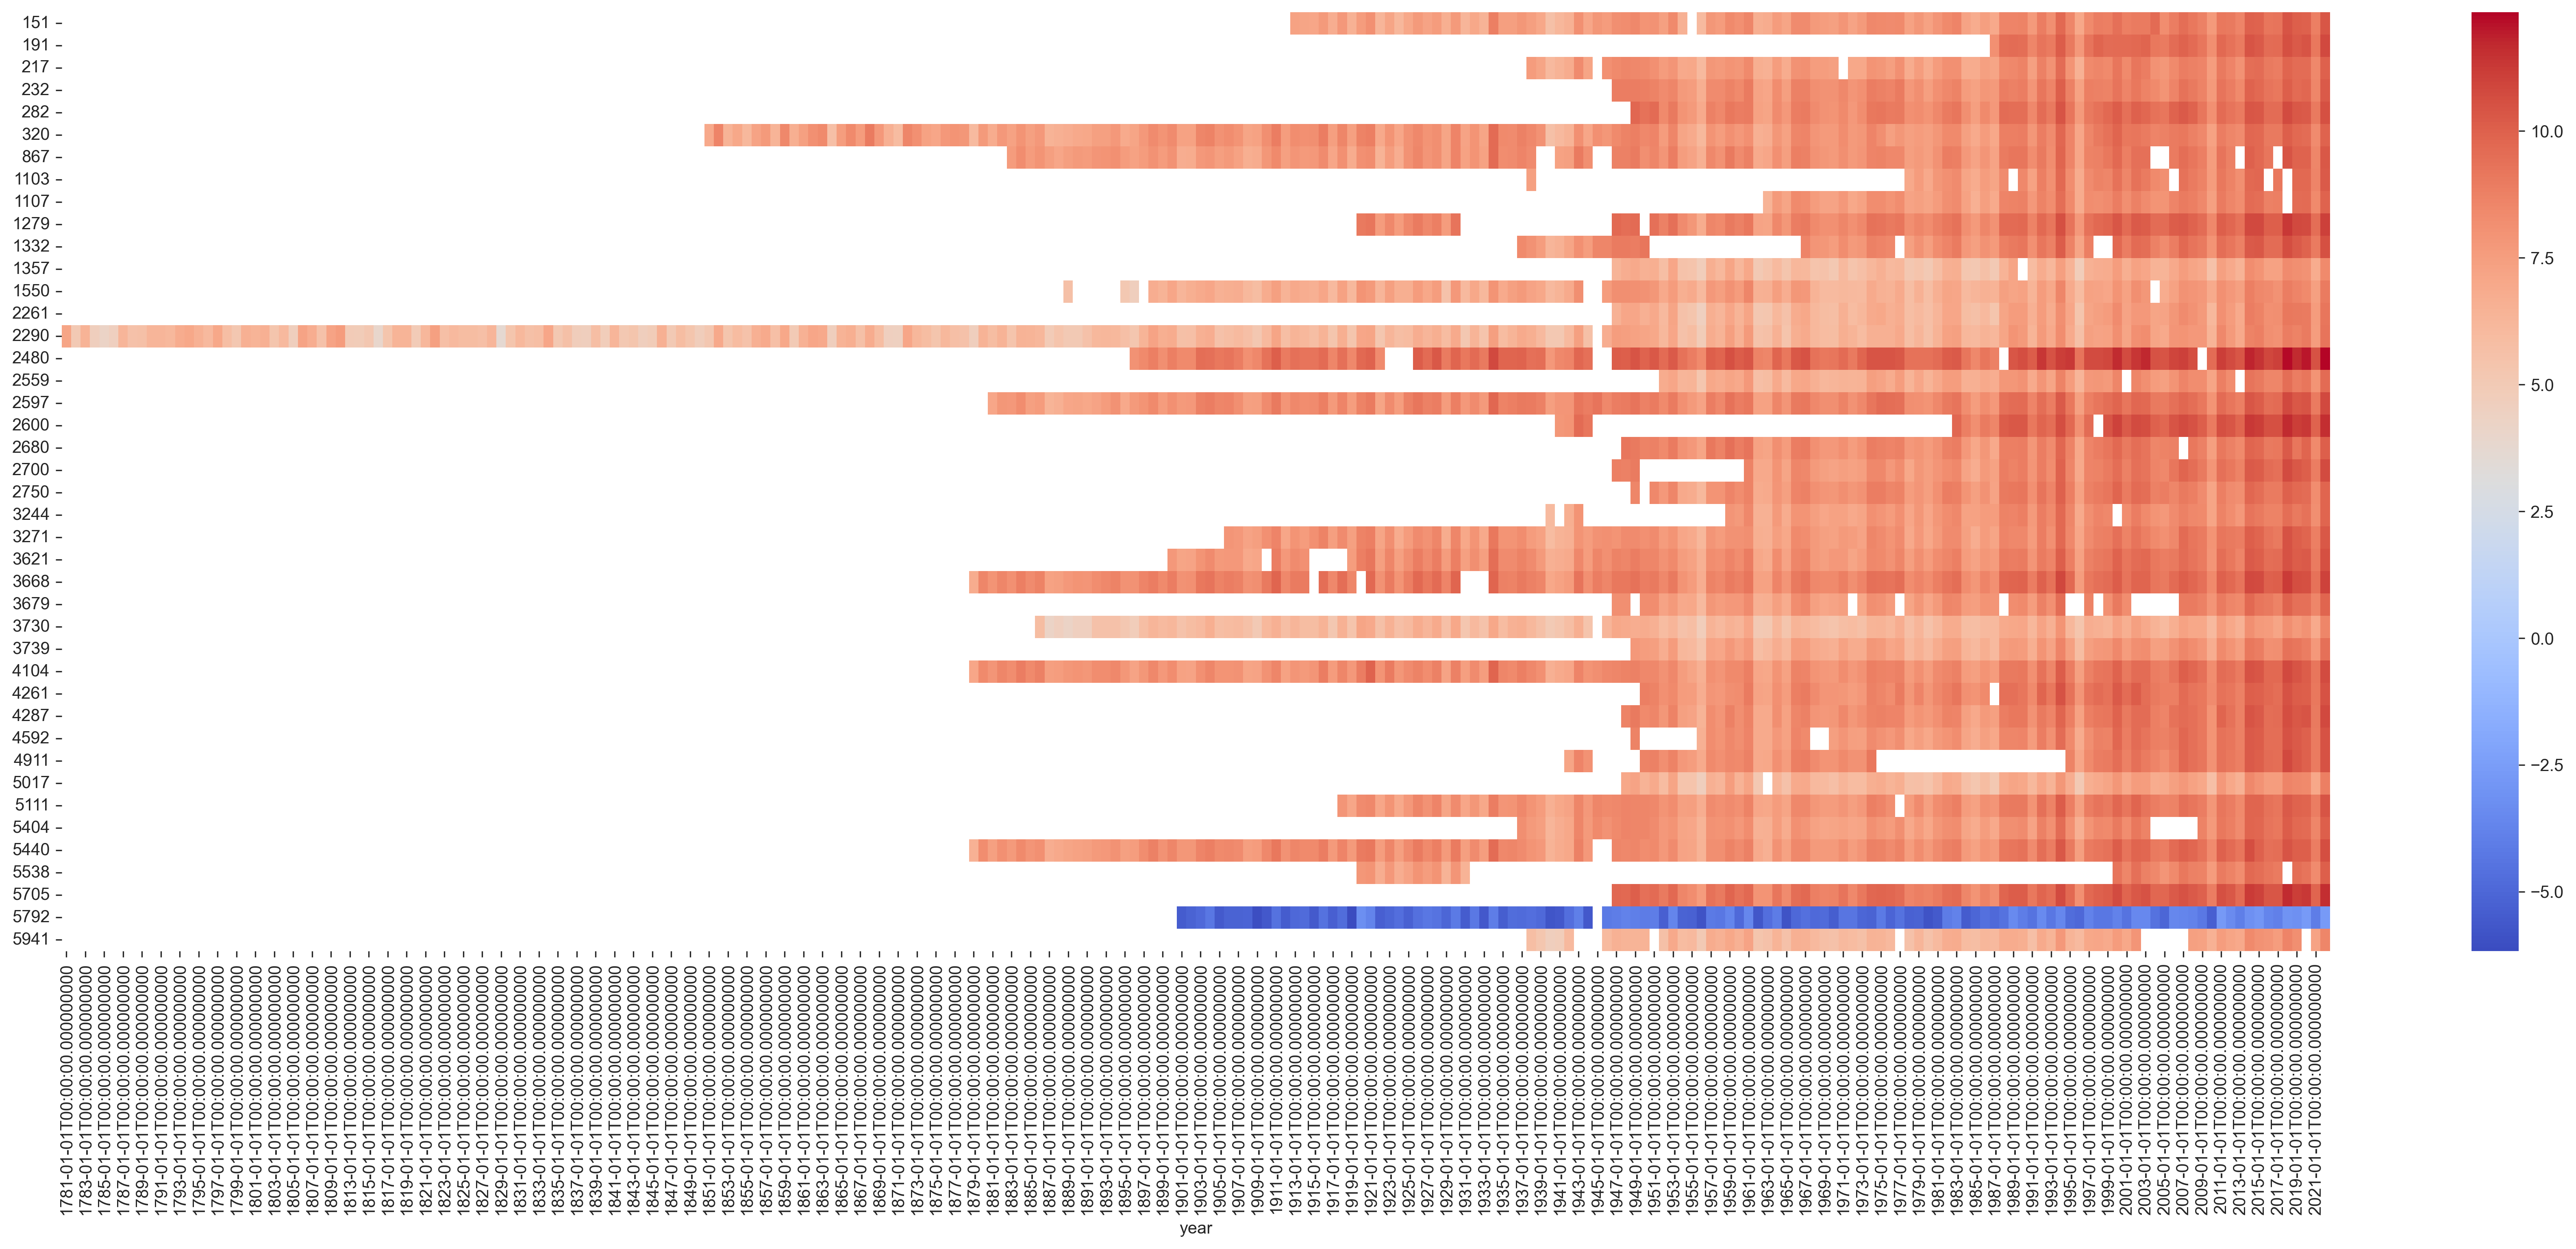

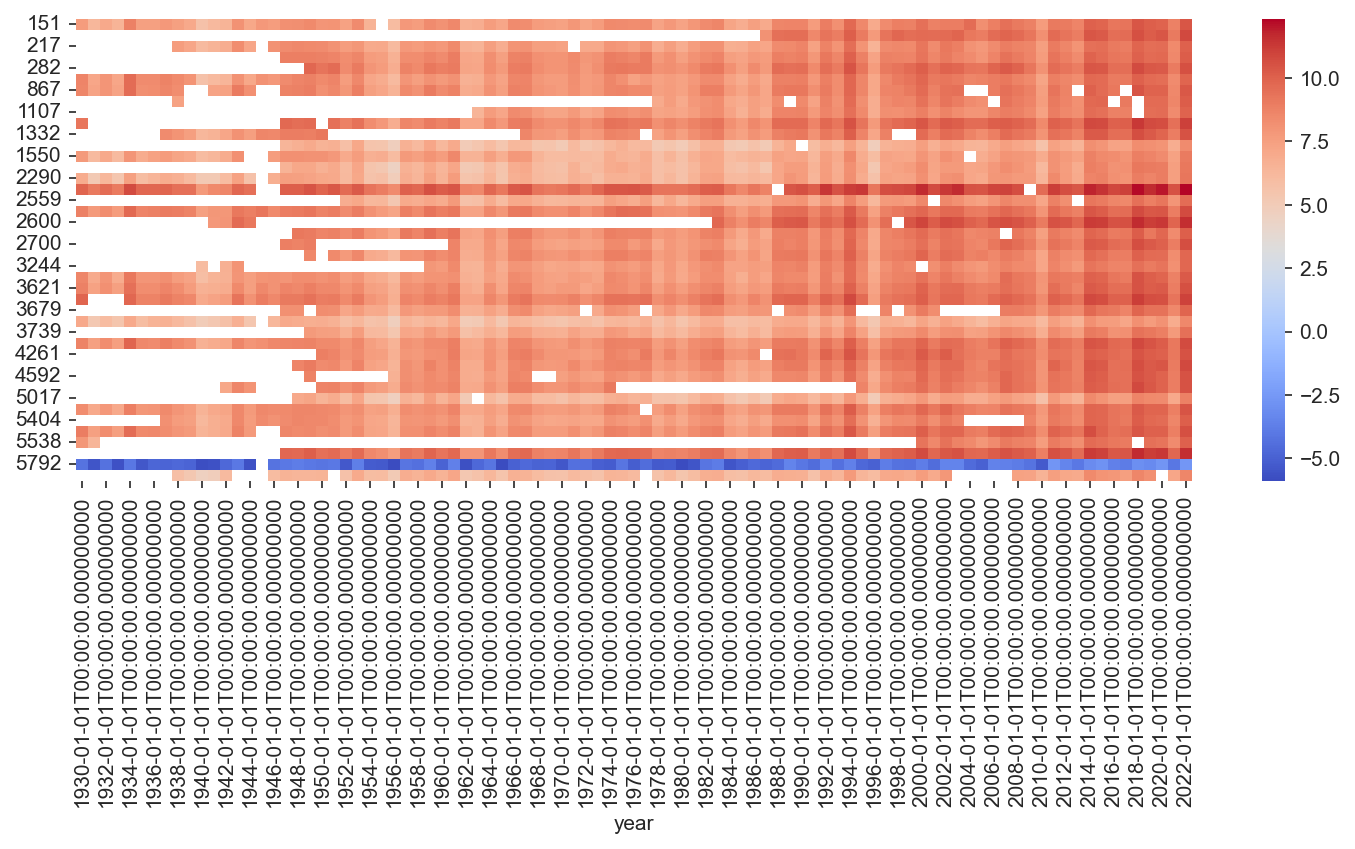

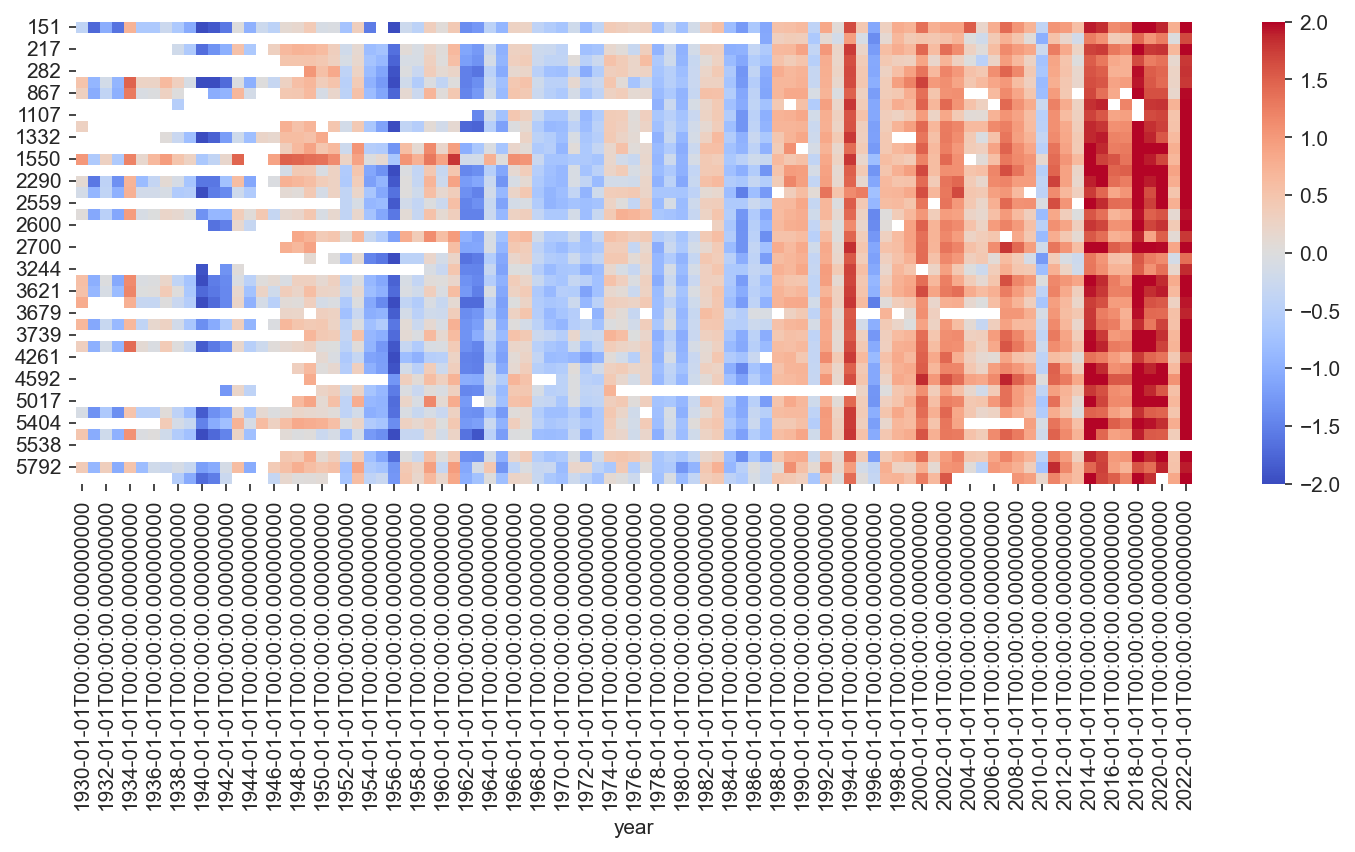

In [61]:
if not df_temp.empty:
    # Calculate the mean annual temperature between 1961 and 1990 for each station
    mean_temp = df_temp[(df_temp.index >= pd.Timestamp('1971-01-01')) & (df_temp.index <= pd.Timestamp('1999-12-31'))].mean()

    # Calculate temperature differences relative to the mean
    df_temp_diff = df_temp - mean_temp

    # Plot the warming stripes
    sns.set_style('ticks')

    # Plot 1
    fig1, ax1 = plt.subplots(dpi=300, figsize=(30, 10))
    sns.heatmap(df_temp.T, cmap='coolwarm', ax=ax1)
    fig1.savefig('BY_Annual_Temp_Stripes_01.png')

    # Plot 2
    fig2, ax2 = plt.subplots(dpi=150, figsize=(12, 4))
    sns.heatmap(df_temp[df_temp.index >= pd.Timestamp('1930-01-01')].T, cmap='coolwarm', ax=ax2)
    fig2.savefig('BY_Annual_Temp_Stripes_02.png')

    # Plot 3
    fig3, ax3 = plt.subplots(dpi=150, figsize=(12, 4))
    sns.heatmap(df_temp_diff[df_temp_diff.index >= pd.Timestamp('1930-01-01')].T, cmap='coolwarm', vmin=-2, vmax=2, ax=ax3)
    fig3.savefig('BY_Annual_Temp_Diff_Stripes_02.png')
else:
    print("DataFrame is empty. No temperature data available.")